In [28]:
import os
import torch
import open_clip
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [29]:
freqs_incap = pd.read_csv('../metadata/freqs/class_frequency_incap_imagenet_ori.txt', sep='\t', header=None, names=['class', 'freq'])['freq'].to_numpy()
freqs_laionet = pd.read_csv('../metadata/freqs/class_frequency_laionet_thresh0.7_ori.txt', sep='\t', header=None, names=['class', 'freq'])['freq'].to_numpy()
freqs_cc12m = pd.read_csv('../metadata/freqs/class_frequency_cc12m_cls_imagenet_ori.txt', sep='\t', header=None, names=['class', 'freq'])['freq'].to_numpy()
freqs_yfcc15m = pd.read_csv('../metadata/freqs/class_frequency_yfcc15m_cls_dedup_ori.txt', sep='\t', header=None, names=['class', 'freq'])['freq'].to_numpy()
freqs_laion400m = pd.read_csv('../metadata/freqs/class_frequency_laion400m_imagenet_ori.txt', sep='\t', header=None, names=['class', 'freq'])['freq'].to_numpy()
freqs_laion2b = pd.read_csv('../metadata/freqs/class_frequency_laion2b_imagenet_ori.txt', sep='\t', header=None, names=['class', 'freq'])['freq'].to_numpy()
freqs_metaclip_400m = pd.read_csv('../metadata/freqs/class_frequency_metaclip_400m_imagenet_ori.txt', sep='\t', header=None, names=['class', 'freq'])['freq'].to_numpy()
freqs_metaclip_fullcc = pd.read_csv('../metadata/freqs/class_frequency_metaclip_fullcc_imagenet_ori.txt', sep='\t', header=None, names=['class', 'freq'])['freq'].to_numpy()

freq_dict = {'IN-Caps': freqs_incap, 'LAIONet-3M': freqs_laionet, 'CC-12M': freqs_cc12m, 'YFCC-15M': freqs_yfcc15m, 'YFCC-Cls': freqs_yfcc15m, 'LAION-400M': freqs_laion400m, 'LAION-2B': freqs_laion2b, 'MetaCLIP-400M': freqs_metaclip_400m, 'MetaCLIP-2.5B': freqs_metaclip_fullcc}
freq_df = pd.DataFrame(freq_dict)

In [30]:
def get_metrics(models, root='../exps_clip/logs_pretrained/{}/metrics/metrics_imagenet_zeroshot_val_latest.pt'):
    metrics = []
    for model, pretrained in models:
        if 'EVA' in model:
            continue
        path = root.format('{}-{}'.format(model, pretrained))
        if os.path.exists(path):
            metric = torch.load(path, map_location='cpu')
            backbone, dataset = parse_model(model), parse_dataset(pretrained)
            freqs = freq_dict[dataset]
            df_dict = {'Model': 'CLIP', 'Backbone': backbone, 'Dataset': dataset}
            df_dict.update(make_metrics(metric, freqs))
            metrics.append(pd.DataFrame(df_dict, index=[0]))
    metrics = pd.concat(metrics)
    metrics = metrics.reset_index(drop=True)
    return metrics

def make_metrics(metric, freqs):
    out = {}
    accs, preds = metric['per_class_accs'].numpy(), metric['per_class_pred_cnt'].numpy()
    corr_acc, corr_pred, corr_pred_acc = spearmanr(freqs, accs).statistic, spearmanr(freqs, preds).statistic, spearmanr(accs, preds).statistic
    out['top1'], out['corr_acc'], out['corr_pred'], out['corr_pred_acc'] = accs.mean(), corr_acc, corr_pred, corr_pred_acc
    try:
        Sw_invSb, cos_M_all, cos_W_all, cos_M_nearest, cos_W_nearest, cos_within \
            = metric['Sw_invSb'].numpy(), metric['cos_M_all'].numpy(), metric['cos_W_all'].numpy(), metric['cos_M_nearest'].numpy(), metric['cos_W_nearest'].numpy(), metric['cos_within'].numpy()
        corr_Sw_invSb, corr_cos_M_all, corr_cos_W_all, corr_cos_M_nearest, corr_cos_W_nearest, corr_cos_within \
            = spearmanr(freqs, Sw_invSb).statistic, spearmanr(freqs, cos_M_all).statistic, \
            spearmanr(freqs, cos_W_all).statistic, spearmanr(freqs, cos_M_nearest).statistic, spearmanr(freqs, cos_W_nearest).statistic, spearmanr(freqs, cos_within).statistic
        corr_Sw_invSb_acc, corr_cos_M_all_acc, corr_cos_W_all_acc, corr_cos_M_nearest_acc, corr_cos_W_nearest_acc, corr_cos_within_acc \
            = spearmanr(accs, Sw_invSb).statistic, spearmanr(accs, cos_M_all).statistic, spearmanr(accs, cos_W_all).statistic, \
                spearmanr(accs, cos_M_nearest).statistic, spearmanr(accs, cos_W_nearest).statistic, spearmanr(accs, cos_within).statistic
        out['Sw_invSb'], out['cos_M'], out['cos_W'], out['cos_M_nearest'], out['cos_W_nearest'], out['cos_within'] \
            = Sw_invSb.mean(), cos_M_all.mean(), cos_W_all.mean(), cos_M_nearest.mean(), cos_W_nearest.mean(), cos_within.mean()
        out['corr_Sw_invSb'], out['corr_cos_M_all'], out['corr_cos_W_all'], out['corr_cos_M_nearest'], out['corr_cos_W_nearest'], out['corr_cos_within'] \
            = corr_Sw_invSb, corr_cos_M_all, corr_cos_W_all, corr_cos_M_nearest, corr_cos_W_nearest, corr_cos_within
        out['corr_Sw_invSb_acc'], out['corr_cos_M_all_acc'], out['corr_cos_W_all_acc'], out['corr_cos_M_nearest_acc'], out['corr_cos_W_nearest_acc'], out['corr_cos_within_acc'] \
            = corr_Sw_invSb_acc, corr_cos_M_all_acc, corr_cos_W_all_acc, corr_cos_M_nearest_acc, corr_cos_W_nearest_acc, corr_cos_within_acc
    except:
        print('NC metrics not supported')
    return out

def get_our_metrics(paths):
    metrics = []
    for path in paths:
        if 'stats_val.jsonl' in path:
            path = path.replace('stats_val.jsonl', 'metrics/metrics_imagenet_zeroshot_val_latest.pt')
        if os.path.exists(path):
            df_dict = {}
            metric = torch.load(path, map_location='cpu')
            df_dict['Dataset'] = parse_dataset(path)
            df_dict['Model'] = 'CLIP' if 'open_clip' in path else 'SL'
            if df_dict['Model'] == 'CLIP':
                freqs = freq_dict[df_dict['Dataset']]
            else:
                freqs = freq_dict[df_dict['Dataset']] if 'yfcc' not in path else freq_dict['YFCC-Cls']
            metric_dict = make_metrics(metric, freqs)
            df_dict.update(metric_dict)
            metrics.append(pd.DataFrame(df_dict, index=[0]))
    metrics = pd.concat(metrics)
    metrics = metrics.reset_index(drop=True)
    return metrics

def parse_dataset(pretrained):
    if 'cc12m' in pretrained:
        dataset = 'CC-12M'
    elif 'yfcc15m' in pretrained:
        dataset = 'YFCC-15M'
    elif 'metaclip_400m' in pretrained:
        dataset = 'MetaCLIP-400M'
    elif 'metaclip_fullcc' in pretrained:
        dataset = 'MetaCLIP-2.5B'
    elif 'laion400m' in pretrained:
        dataset = 'LAION-400M'
    elif 'laion2b' in pretrained:
        dataset = 'LAION-2B'
    else:
        dataset = 'LAIONet-3M'
    return dataset

def parse_model(model):
    if 'RN' in model:
        model = 'ResNet'
    elif 'convnext' in model:
        model = 'ConvNeXt'
    elif 'ViT' in model:
        model = 'ViT'
    elif 'EVA' in model:
        model = 'EVA'
    else:
        raise NotImplementedError
    return model

In [31]:
models = open_clip.list_pretrained()
models = [item for item in models if 'cc12m' in item[1] or 'yfcc15m' in item[1] or 'laion400m' in item[1] or 'laion2b' in item[1] or 'metaclip' in item[1]]
our_paths = ['../exps_sup/output/rn50_laionet_supcls_bs256_20240111_223004/metrics/metrics_val_latest.pt',
             '../exps_sup/output/rn50_cc12mcls_supcls_bs256/metrics/metrics_val_latest.pt',
             '../exps_sup/output/rn50_yfcc15mcls_supcls_bs256/metrics/metrics_val_latest.pt',
             '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.7/metrics/metrics_imagenet_zeroshot_val_latest.pt',
             '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.7_frac0.5/metrics/metrics_imagenet_zeroshot_val_latest.pt',]

In [19]:
metrics = get_metrics(models)
our_metrics = get_our_metrics(our_paths)
metrics = pd.concat([metrics, our_metrics]).reset_index(drop=True)
metrics.loc[:, 'top1'] *= 100

NC metrics not supported


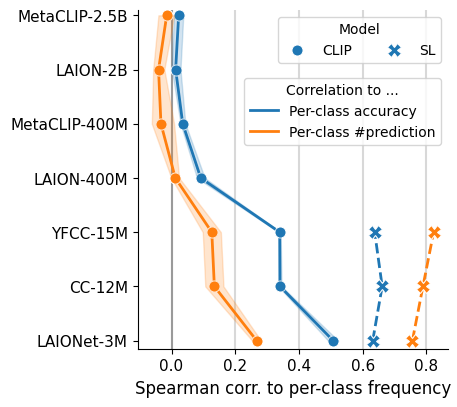

In [20]:
palette = sns.color_palette('tab20')
palette1 = [palette[3], palette[2], palette[5], palette[4], palette[1], palette[0]]
palette2 = [palette[2], palette[2], palette[4], palette[4], palette[0], palette[0]]
datasets = ['LAIONet-3M', 'CC-12M', 'YFCC-15M', 'LAION-400M', 'MetaCLIP-400M', 'LAION-2B', 'MetaCLIP-2.5B']
backbones = ['ResNet', 'ConvNeXt', 'ViT']

fig, ax = plt.subplots(1, 1, figsize=(4, 4.4))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axvline(x=0, color='gray', linestyle='-', linewidth=1.5, alpha=0.7, zorder=-10)
ax.grid(axis='x', color='gray', linestyle='-', linewidth=1.5, alpha=0.3)

# reorder datasets by the order of the list datasets
metrics = metrics.set_index('Dataset').loc[datasets].reset_index()
clip_metrics = metrics[metrics['Model'] == 'CLIP']
sl_metrics = metrics[metrics['Model'] == 'SL']
sns.lineplot(data=clip_metrics, x='corr_acc', y='Dataset', lw=2, color='tab:blue', ax=ax, label='Per-class accuracy', orient='y', err_kws={'zorder': 2.5, 'interpolate': True})
sns.lineplot(data=clip_metrics, x='corr_pred', y='Dataset', lw=2, color='tab:orange', ax=ax, label='Per-class #prediction', orient='y', err_kws={'zorder': 2.5, 'interpolate': True})
sns.lineplot(data=clip_metrics, x='corr_acc', y='Dataset', marker='o', color='tab:blue', lw=0, markersize=8, ax=ax, label='CLIP', orient='y', errorbar=None)
sns.lineplot(data=clip_metrics, x='corr_pred', y='Dataset', marker='o', color='tab:orange', lw=0, markersize=8, ax=ax, orient='y', errorbar=None)
sns.lineplot(data=sl_metrics, x='corr_acc', y='Dataset', lw=2, ls='--', ax=ax, orient='y', err_kws={'zorder': 2.5}, err_style='band')
sns.lineplot(data=sl_metrics, x='corr_pred', y='Dataset', lw=2, ls='--', ax=ax, orient='y', err_kws={'zorder': 2.5}, err_style='band')
sns.lineplot(data=sl_metrics, x='corr_acc', y='Dataset', lw=0, marker='X', color='tab:blue', markersize=10, ax=ax, label='SL', orient='y')
sns.lineplot(data=sl_metrics, x='corr_pred', y='Dataset', lw=0, marker='X', color='tab:orange', markersize=10, ax=ax, orient='y')

handles, labels = ax.get_legend_handles_labels()
legend1 = plt.legend(handles[:2], labels[:2], title='Correlation to ...', loc='upper right', bbox_to_anchor=(1.0, 0.82), fontsize=10)
plt.legend(handles[2:], labels[2:], title='Model', ncols=2, fontsize=10)
plt.gca().add_artist(legend1)
ax.set_ylim(-.15, 6.1)
ax.set_ylabel('')
ax.set_xlabel('Spearman corr. to per-class frequency', fontsize=12)
ax.xaxis.set_tick_params(labelsize=11, rotation=0)
ax.yaxis.set_tick_params(labelsize=11, rotation=0)
plt.savefig('figs_new/all_corrs.pdf', bbox_inches='tight', dpi=300)

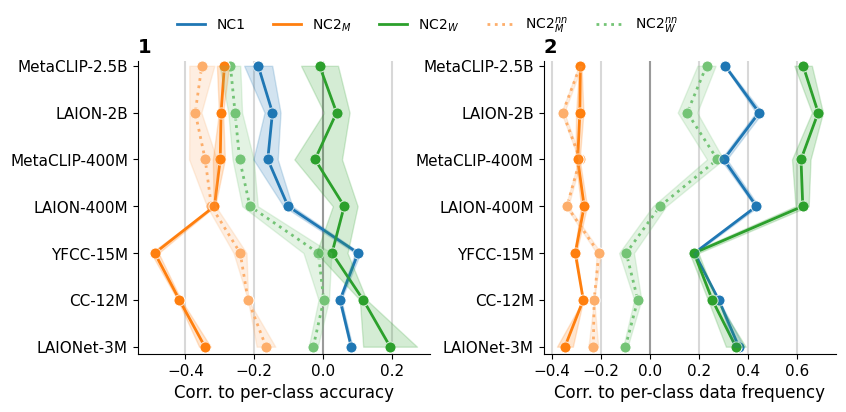

In [27]:
tab20 = sns.color_palette('tab20c')
datasets = ['LAIONet-3M', 'CC-12M', 'YFCC-15M', 'LAION-400M', 'MetaCLIP-400M', 'LAION-2B', 'MetaCLIP-2.5B']
fig, ax = plt.subplots(1, 2, sharey=False, figsize=(10, 3.8))
# frame off
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[0].axvline(x=0, color='gray', linestyle='-', linewidth=1.5, alpha=0.7, zorder=-10)
ax[0].grid(axis='x', color='gray', linestyle='-', linewidth=1.5, alpha=0.3)
ax[1].axvline(x=0, color='gray', linestyle='-', linewidth=1.5, alpha=0.7, zorder=-10)
ax[1].grid(axis='x', color='gray', linestyle='-', linewidth=1.5, alpha=0.3)

# reorder datasets by the order of the list datasets
metrics = metrics.set_index('Dataset').loc[datasets].reset_index()
clip_metrics = metrics[metrics['Model'] == 'CLIP']
sns.lineplot(data=clip_metrics, x='corr_cos_M_nearest_acc', y='Dataset', lw=2, ls=':', color=tab20[6], ax=ax[0], label='NC2$_M^{nn}$', orient='y', err_kws={'zorder': 2.5, 'interpolate': True})
sns.lineplot(data=clip_metrics, x='corr_cos_M_nearest_acc', y='Dataset', marker='o', color=tab20[6], lw=0, markersize=8, ax=ax[0], orient='y', errorbar=None)
sns.lineplot(data=clip_metrics, x='corr_cos_W_nearest_acc', y='Dataset', lw=2, ls=':', color=tab20[9], ax=ax[0], label='NC2$_W^{nn}$', orient='y', err_kws={'zorder': 2.5, 'interpolate': True})
sns.lineplot(data=clip_metrics, x='corr_cos_W_nearest_acc', y='Dataset', marker='o', color=tab20[9], lw=0, markersize=8, ax=ax[0], orient='y', errorbar=None)
sns.lineplot(data=clip_metrics, x='corr_Sw_invSb_acc', y='Dataset', lw=2, color='tab:blue', ax=ax[0], label='NC1', orient='y', err_kws={'zorder': 2.5, 'interpolate': True})
sns.lineplot(data=clip_metrics, x='corr_Sw_invSb_acc', y='Dataset', marker='o', color='tab:blue', lw=0, markersize=8, ax=ax[0], orient='y', errorbar=None)
sns.lineplot(data=clip_metrics, x='corr_cos_M_all_acc', y='Dataset', lw=2, color='tab:orange', ax=ax[0], label='NC2$_M$', orient='y', err_kws={'zorder': 2.5, 'interpolate': True})
sns.lineplot(data=clip_metrics, x='corr_cos_M_all_acc', y='Dataset', marker='o', color='tab:orange', lw=0, markersize=8, ax=ax[0], orient='y', errorbar=None)
sns.lineplot(data=clip_metrics, x='corr_cos_W_all_acc', y='Dataset', lw=2, color='tab:green', ax=ax[0], label='NC2$_W$', orient='y', err_kws={'zorder': 2.5, 'interpolate': True})
sns.lineplot(data=clip_metrics, x='corr_cos_W_all_acc', y='Dataset', marker='o', color='tab:green', lw=0, markersize=8, ax=ax[0], orient='y', errorbar=None)

sns.lineplot(data=clip_metrics, x='corr_cos_M_nearest', y='Dataset', lw=2, ls=':', color=tab20[6], ax=ax[1], label='NC2$_M^{nn}$', orient='y', err_kws={'zorder': 2.5, 'interpolate': True})
sns.lineplot(data=clip_metrics, x='corr_cos_M_nearest', y='Dataset', marker='o', color=tab20[6], lw=0, markersize=8, ax=ax[1], orient='y', errorbar=None)
sns.lineplot(data=clip_metrics, x='corr_cos_W_nearest', y='Dataset', lw=2, ls=':', color=tab20[9], ax=ax[1], label='NC2$_W^{nn}$', orient='y', err_kws={'zorder': 2.5, 'interpolate': True})
sns.lineplot(data=clip_metrics, x='corr_cos_W_nearest', y='Dataset', marker='o', color=tab20[9], lw=0, markersize=8, ax=ax[1], orient='y', errorbar=None)
sns.lineplot(data=clip_metrics, x='corr_Sw_invSb', y='Dataset', lw=2, color='tab:blue', ax=ax[1], label='NC1', orient='y', err_kws={'zorder': 2.5, 'interpolate': True})
sns.lineplot(data=clip_metrics, x='corr_Sw_invSb', y='Dataset', marker='o', color='tab:blue', lw=0, markersize=8, ax=ax[1], orient='y', errorbar=None)
sns.lineplot(data=clip_metrics, x='corr_cos_M_all', y='Dataset', lw=2, color='tab:orange', ax=ax[1], label='NC2$_M$', orient='y', err_kws={'zorder': 2.5, 'interpolate': True})
sns.lineplot(data=clip_metrics, x='corr_cos_M_all', y='Dataset', marker='o', color='tab:orange', lw=0, markersize=8, ax=ax[1], orient='y', errorbar=None)
sns.lineplot(data=clip_metrics, x='corr_cos_W_all', y='Dataset', lw=2, color='tab:green', ax=ax[1], label='NC2$_W$', orient='y', err_kws={'zorder': 2.5, 'interpolate': True})
sns.lineplot(data=clip_metrics, x='corr_cos_W_all', y='Dataset', marker='o', color='tab:green', lw=0, markersize=8, ax=ax[1], orient='y', errorbar=None)

ax[0].text(0, 1.03, '1', fontsize=14, fontweight='bold', transform=ax[0].transAxes)
ax[1].text(0, 1.03, '2', fontsize=14, fontweight='bold', transform=ax[1].transAxes)

ax[0].legend().remove()
ax[1].legend().remove()
handles, labels = ax[0].get_legend_handles_labels()
handles, labels = handles[2:] + handles[:2], labels[2:] + labels[:2]
legend1 = plt.legend(handles, labels, ncols=len(handles), loc='upper right', bbox_to_anchor=(.5, 1.2), frameon=False, fontsize=10)
ax[0].set_ylim(-.15, 6.1)
ax[1].set_ylim(-.15, 6.1)
ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[0].set_xlabel('Corr. to per-class accuracy', fontsize=12)
ax[1].set_xlabel('Corr. to per-class data frequency', fontsize=12)
ax[0].xaxis.set_tick_params(labelsize=11, rotation=0)
ax[0].yaxis.set_tick_params(labelsize=11, rotation=0)
ax[1].xaxis.set_tick_params(labelsize=11, rotation=0)
ax[1].yaxis.set_tick_params(labelsize=11, rotation=0)

ax[0].set_box_aspect(1)
ax[1].set_box_aspect(1)
plt.subplots_adjust(hspace=0., wspace=0.1)
plt.savefig('figs_new/all2all_corrs.pdf', bbox_inches='tight', dpi=300)

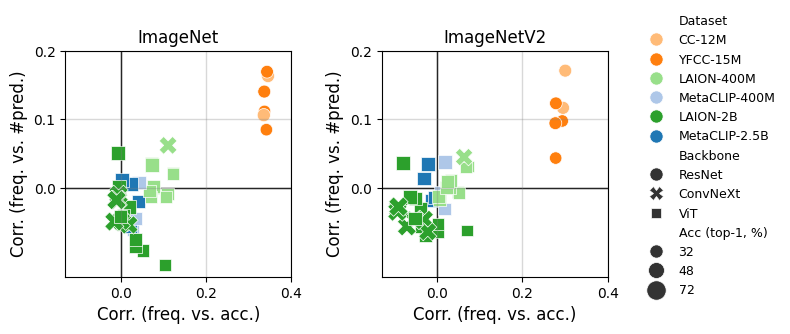

In [115]:
metrics = get_metrics(models, root='../exps_clip/logs_pretrained/{}/metrics/metrics_imagenet_zeroshot_val_latest.pt')
metrics.loc[:, 'top1'] *= 100
metrics_v2 = get_metrics(models, root='../exps_clip/logs_pretrained/{}/metrics/metrics_imagenet_zeroshot_v2_latest.pt')
metrics_v2.loc[:, 'top1'] *= 100

palette = sns.color_palette('tab20')
palette1 = [palette[3], palette[2], palette[5], palette[1], palette[4], palette[0]]
palette2 = [palette[2], palette[2], palette[4], palette[0], palette[4], palette[0]]
hue_order = ['CC-12M', 'YFCC-15M', 'LAION-400M', 'MetaCLIP-400M', 'LAION-2B', 'MetaCLIP-2.5B']
style_order = ['ResNet', 'ConvNeXt', 'ViT']

fig, ax = plt.subplots(1, 2, sharey=False, figsize=(7, 3))

ax[0].grid(color='gray', linestyle='-', linewidth=1, alpha=0.3)
ax[1].grid(color='gray', linestyle='-', linewidth=1, alpha=0.3)
ax[0].axvline(x=0, color='black', linestyle='-', linewidth=1, zorder=0)
ax[1].axvline(x=0, color='black', linestyle='-', linewidth=1, zorder=0)
ax[0].axhline(y=0, color='black', linestyle='-', linewidth=1, zorder=0)
ax[1].axhline(y=0, color='black', linestyle='-', linewidth=1, zorder=0)
sns.scatterplot(data=metrics, x='corr_acc', y='corr_pred', hue='Dataset', style='Backbone', size='top1', sizes=(80, 200), s=90, alpha=1, linewidth=.5, ec='w', ax=ax[0], hue_order=hue_order, style_order=style_order, palette=palette1)
sns.scatterplot(data=metrics_v2, x='corr_acc', y='corr_pred', hue='Dataset', style='Backbone', size='top1', sizes=(80, 200), s=90, alpha=1, linewidth=.5, ec='w', ax=ax[1], hue_order=hue_order, style_order=style_order, palette=palette1, legend='brief')
ax[0].legend().remove()

ax[0].set_xlabel('Corr. (freq. vs. acc.)', fontsize=12)
ax[1].set_xlabel('Corr. (freq. vs. acc.)', fontsize=12)
ax[0].set_ylabel('Corr. (freq. vs. #pred.)', fontsize=12)
ax[1].set_ylabel('Corr. (freq. vs. #pred.)', fontsize=12)

ax[0].set_box_aspect(1)
ax[1].set_box_aspect(1)

ax[0].set_ylim([-.13, .2])
ax[1].set_ylim([-.13, .2])
ax[0].set_xlim([-.13, .4])
ax[1].set_xlim([-.13, .4])
ax[0].set_yticks([0, .1, .2])
ax[1].set_yticks([0, .1, .2])

ax[0].yaxis.set_tick_params(rotation=0)
ax[1].yaxis.set_tick_params(rotation=0)

ax[0].set_title('ImageNet')
ax[1].set_title('ImageNetV2')

plt.subplots_adjust(wspace=.4, hspace=0)

l = matplotlib.lines.Line2D([], [], color="none")
handles, labels = ax[1].get_legend_handles_labels()
handles = handles[:7] + handles[-4:] + [handles[7], handles[8], handles[10], handles[13]]
labels = labels[:7] + labels[-4:] + ["Acc (top-1, %)", labels[8], labels[10], labels[13]]
plt.legend(handles, labels, loc='lower center', bbox_to_anchor=(1.45, -.14), ncol=1, fontsize=9, frameon=False, columnspacing=0.8)

plt.savefig('figs_new/all_openclip.pdf', bbox_inches='tight', dpi=300)